# Fit Multiple Noisy Traces HH to HH

In [1]:
import pandas as pd
import numpy as np

In [2]:
from brian2 import *
from brian2tools import *

prefs.codegen.target = 'cython'  # weave is not multiprocess-safe!

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


In [3]:
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV
params_correct = {'gl': float(5e-5*siemens*cm**-2 * area),
                  'g_na': float(100*msiemens*cm**-2 * area),
                  'g_kd': float(30*msiemens*cm**-2 * area),
                  'Cm': float(1*ufarad*cm**-2 * area), 
                  'EK': float(-90*mV),
                  'ENa': float(50*mV),}

dt = 0.01*ms
defaultclock.dt = dt

In [4]:
params_correct

{'gl': 1e-08,
 'g_na': 2e-05,
 'g_kd': 6e-06,
 'Cm': 2e-10,
 'EK': -0.09,
 'ENa': 0.05}

### Load Input and Output

In [5]:
df_inp_traces = pd.read_csv('input_traces_hh.csv')
df_out_traces = pd.read_csv('output_traces_hh.csv')

In [6]:
inp_traces = df_inp_traces.to_numpy()
inp_traces = inp_traces[:4, 1:]
inp_traces

array([[0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
       [2.e-09, 2.e-09, 2.e-09, ..., 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00]])

In [7]:
out_traces = df_out_traces.to_numpy()
out_traces = out_traces[:4, 1:]
out_traces

array([[-63.54211145, -65.52491616, -62.90054542, ..., -81.5252667 ,
        -82.30107475, -82.04870895],
       [-63.78548155, -64.75587972, -64.60550311, ..., -64.42127691,
        -65.13069593, -64.48718384],
       [-62.92648395, -65.82540807, -64.76394825, ..., -64.9418292 ,
        -63.8704734 , -63.17105741],
       [-64.51645049, -66.84945425, -64.64260378, ..., -80.91299455,
        -79.08977935, -82.01562544]])

## Model Fitting 

In [8]:
eqs = Equations(
'''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
Cm   : farad (constant)
''',
EK=-90*mV, ENa=50*mV,
El=-65*mV,
VT=-63*mV)

In [9]:
def callback(res, errors, parameters, index):
    print('index {} errors minimum: {}'.format(index, min(errors)) )

In [10]:
start_scope()
n_opt = NevergradOptimizer(method='DE')

In [11]:
metric = MSEMetric()

In [12]:
res, error = fit_traces(model=eqs, input_var='I', output_var='v',
                       input=inp_traces * amp, output=out_traces*mV, dt=dt,
                       method='exponential_euler',
                       callback=callback,
                       gl = [1e-09 *siemens, 1e-07 *siemens],
                       g_na = [2e-06*siemens, 2e-04*siemens],
                       g_kd = [6e-07*siemens, 6e-05*siemens],
                       Cm=[0.1*ufarad*cm**-2 * area, 2*ufarad*cm**-2 * area],
                       n_rounds=50, n_samples=30, optimizer=n_opt, 
                       metric=MSEMetric())

index 0 errors minimum: 0.8925136480426961
index 1 errors minimum: 0.9134703537555928
index 2 errors minimum: 0.8823389157436652
index 3 errors minimum: 0.8878826556340373
index 4 errors minimum: 0.8823389157436652
index 5 errors minimum: 0.8589325372999923
index 6 errors minimum: 0.8660871158488542
index 7 errors minimum: 0.8751927940641449
index 8 errors minimum: 0.8727985736236946
index 9 errors minimum: 0.8642025909506452
index 10 errors minimum: 0.859998894001004
index 11 errors minimum: 0.8618639424656825
index 12 errors minimum: 0.8729636774903216
index 13 errors minimum: 0.8606330357148531
index 14 errors minimum: 0.8589704425134729
index 15 errors minimum: 0.8623790135169311
index 16 errors minimum: 0.8646301866549655
index 17 errors minimum: 0.8581180839674256
index 18 errors minimum: 0.8595195457576964
index 19 errors minimum: 0.8589657734750881
index 20 errors minimum: 0.860061698206482
index 21 errors minimum: 0.8574526646510183
index 22 errors minimum: 0.8634532184845674


In [13]:
print('Goal parameters:')
for param in params_correct.items():
    print(param)

Goal parameters:
('gl', 1e-08)
('g_na', 2e-05)
('g_kd', 6e-06)
('Cm', 2e-10)
('EK', -0.09)
('ENa', 0.05)


In [14]:
print('Result parameters:')
for param in res.items():
    print(param)

Result parameters:
('g_na', 5.071643412511201e-05)
('gl', 9.293118699792661e-08)
('g_kd', 2.4252955877827484e-05)
('Cm', 1.9229867261121183e-10)


## Results Visualization

In [15]:
start_scope()
fits = generate_fits(model=eqs, method='exponential_euler', params=res,
                     input=inp_traces * amp, input_var='I', output_var='v',
                     dt=dt, param_init={'v': -65*mV})

fits/mV

array([[-65.        , -65.        , -65.        , ..., -69.31065491,
        -69.28986291, -69.26917088],
       [-65.        , -65.        , -65.        , ..., -64.55143489,
        -64.55327453, -64.55510557],
       [-65.        , -64.89624603, -64.79299225, ..., -64.37372238,
        -64.37638591, -64.37903705],
       [-65.        , -65.        , -65.        , ..., -68.10878614,
        -68.0937673 , -68.07882051]])

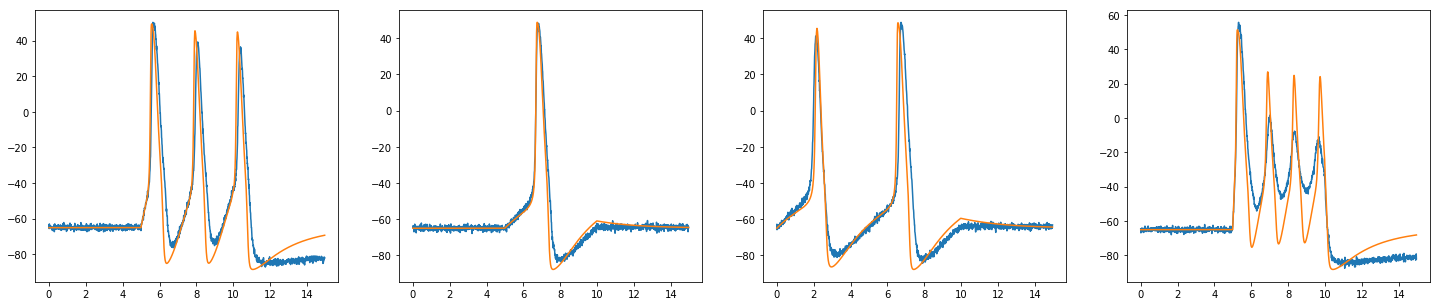

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(25, 5))
ax[0].plot(np.arange(len(out_traces[0]))*dt/ms, out_traces[0]);
ax[0].plot(np.arange(len(fits[0]))*dt/ms, fits[0]/mV);

ax[1].plot(np.arange(len(out_traces[1]))*dt/ms, out_traces[1]);
ax[1].plot(np.arange(len(fits[1]))*dt/ms, fits[1]/mV);

ax[2].plot(np.arange(len(out_traces[2]))*dt/ms, out_traces[2]);
ax[2].plot(np.arange(len(fits[2]))*dt/ms, fits[2]/mV);

ax[3].plot(np.arange(len(out_traces[3]))*dt/ms, out_traces[3]);
ax[3].plot(np.arange(len(fits[3]))*dt/ms, fits[3]/mV);

plt.show()